# Homework 7 

### Oliver Muellerklein with Miao and Jacob B. 

Note: I had taken Miao to the E.R. on Thursday night after we had been working with Jacob on developing this project. 


In [4]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import skimage

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from skimage import data

In [5]:
import os

def getWorkDir():
    return os.getcwd()

def setWorkDir(newPath):
    os.chdir(newPath)
    print("\nNew working directory: ", os.getcwd())
    return True

In [9]:
getWorkDir()

'/Users/kschocz/Documents/berkeley-courses/second-year/fall16/python-ds-seminar/homeworks/hw7/sample_img'

In [8]:
setWorkDir(os.path.join(os.getcwd(), 'sample_img'))


New working directory:  /Users/kschocz/Documents/berkeley-courses/second-year/fall16/python-ds-seminar/homeworks/hw7/sample_img


True

# Step 1: Utility Functions for Image Pre-Processing

In [6]:
def show_images(images, titles = None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images, titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.gray() # Only place in this blog you can't replace 'gray' with 'grey'
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()
    

def getRestoredImg(iimg):
    iimg_restore = restoration.denoise_bilateral(iimg)
    return iimg_restore

def getExposedImg(iimg, hEnhance = False):
    if hEnhance:
        iimg_equ = exposure.equalize_adapthist(iimg)
    else:
        iimg_equ = exposure.equalize_hist(iimg)
    return iimg_equ

def print_cv_score_summary(model, xx, yy, cv):
    scores = cross_val_score(model, xx, yy, cv=cv, n_jobs=1)
    print("mean: {:3f}, stdev: {:3f}".format(
        np.mean(scores), np.std(scores)))

def splitScale(ddat, nPart):
    try:
        from sklearn.model_selection import train_test_split
    except:
        print("Could not import sklearn.cross_validation for train_test_split")
    
    np.random.shuffle(ddat)
    numObs = ddat.shape[0]
    numCol = ddat.shape[1] - 1
    xddat = ddat[:, 1:numCol]
    yddat = ddat[:, numCol]
    
    # remember: many methods work better on scaled X
    xScaled = preprocessing.scale(xddat)
    xTrain, xTest, yTrain, yTest = train_test_split(xScaled, yddat, train_size = nPart, random_state = 1738)
    #xddat.iloc[xTrain] # return dataframe train
    return (xTrain, xTest, yTrain, yTest)
    
   

# Step 2: Load Sample Unicorn Image

And perform some basic pre-processing steps to flatten, gray scale, restore, etc image. 

In [10]:
# Load Data
from skimage import io
from skimage import exposure, restoration
from skimage.color import rgb2gray


#filename = os.path.join(os.getcwd(), 'sample_img/unicorn/unicorn_0004.jpg')
filename = os.path.join(os.getcwd(), 'unicorn/unicorn_0004.jpg')
uni_og = io.imread(filename)
uni_og.shape 
# (360, 480, 3)

# 0 - 1 scaling of data 
# X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)

(360, 480, 3)

### Transform, flatten, process images 

Can perform color restoration, image flattening, gray scaling, exposure equalization, and other techniques for image pre-processing.

In [11]:
uni_restore = getRestoredImg(uni_og)
uni_gray_og = rgb2gray(uni_og)
uni_gray_rest = rgb2gray(uni_restore)
uni_gray_equ = getExposedImg(uni_gray_rest, hEnhance = False)
uni_gray_adapt = getExposedImg(uni_gray_rest, hEnhance = True)
uni_equ = getExposedImg(uni_restore, hEnhance = False)
uni_adapt = getExposedImg(uni_restore, hEnhance = True)

/Users/kschocz/miniconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))
/Users/kschocz/miniconda3/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


## Original image, restored, & gray scaled 

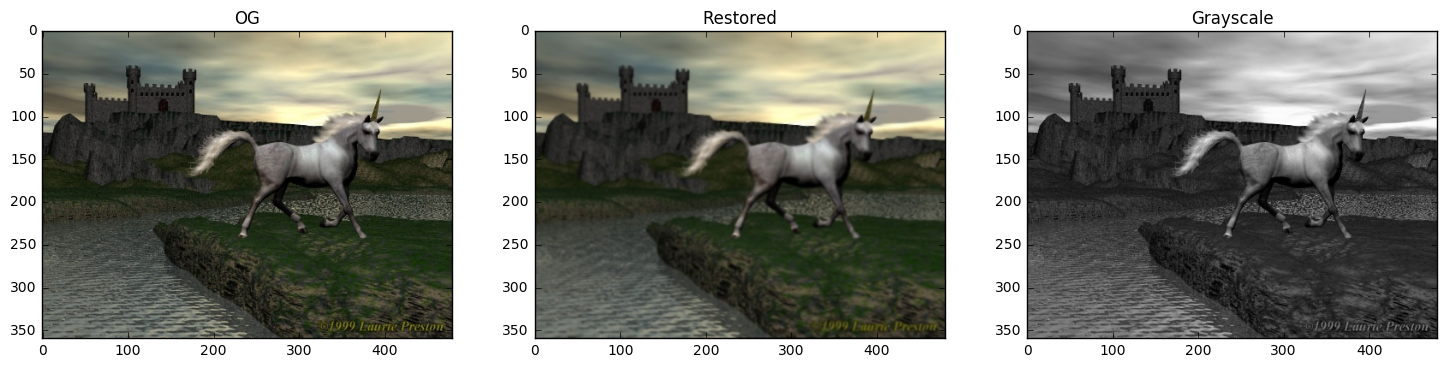

In [12]:
show_images(images = [uni_og, uni_restore, uni_gray_og],
            titles = ["OG", "Restored", "Grayscale"]) 

## Original image, normalized, & adapted 

Normalized and adapted are from exposure equalization (from utility functions above).

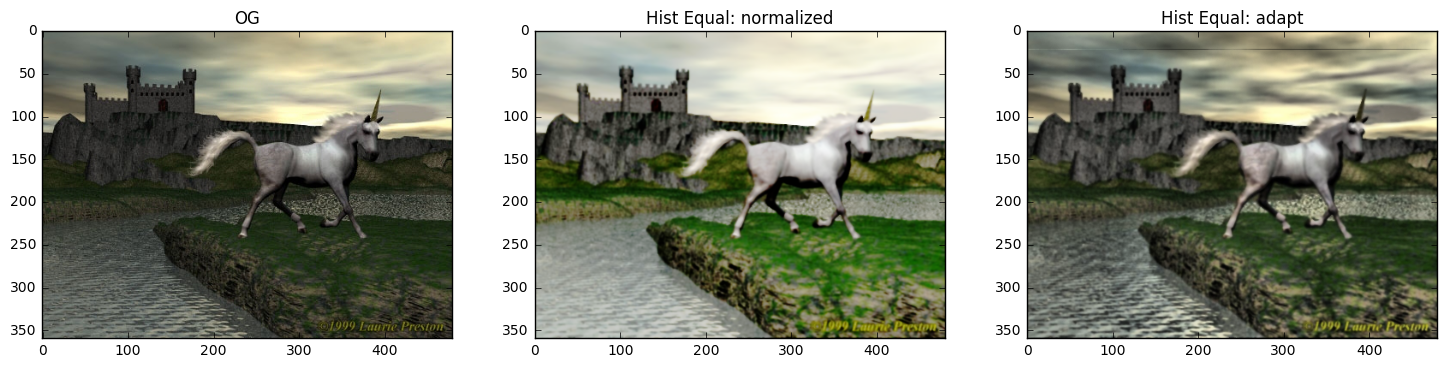

In [13]:
show_images(images = [uni_og, uni_equ, uni_adapt],
            titles = ["OG", "Hist Equal: normalized", "Hist Equal: adapt"])

## Gray scale and equalized

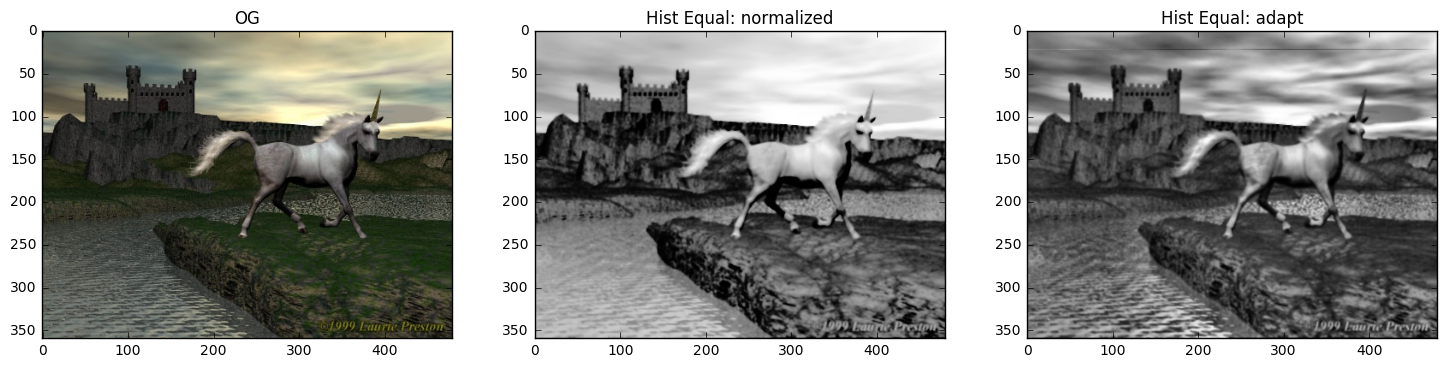

In [14]:
show_images(images = [uni_og, uni_gray_equ, uni_gray_adapt],
            titles = ["OG", "Hist Equal: normalized", "Hist Equal: adapt"])

# Step 3: Get Channel Summary Statistics 

Get mean, median, variance, min, and max (i.e. summary statistics) of images based on channels (R, G, B).

In [15]:
from os import listdir
from time import time
from pylab import imread

#setWorkDir(os.path.join(os.getcwd(), '..'))
MYDIRECTORY = os.getcwd()

In [44]:
def extract_features(image_path_list):
    feature_list = []
    for image_path in image_path_list:
        image_array = imread(image_path)
        feat_size = image_array.size # This feature is simple. You can modify this
        # code to produce more complicated features and to produce multiple
        # features in one function call.
        feature_list.append([image_path, feat_size])
    return feature_list

In [45]:
# We first collect all the local paths to all the images in one list
image_paths = []
categories = listdir(MYDIRECTORY)
for category in categories:
    image_names = listdir(MYDIRECTORY  + "/" + category)
    for name in image_names:
        image_paths.append(MYDIRECTORY + "/" + category + "/" + name)

print("There should be 4244 images, actual number is " + 
    str(len(image_paths)) + ".")

There should be 4244 images, actual number is 811.


In [46]:
categories

['airplanes', 'bear', 'dolphin', 'octopus', 'unicorn']

In [49]:
#image_paths
foo = extract_features(image_paths)

In [50]:
foo[0]

['/Users/echoes/Documents/berkeley-courses/second-year/fall16/python-ds-seminar/homeworks/hw7/sample_img/airplanes/airplanes_0001.jpg',
 195816]

### Ex 1: corners 

In [54]:
from skimage import feature
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform

#tform = AffineTransform(scale=(1.3, 1.1), rotation=1, shear=0.7,
#                        translation=(210, 50))
#image = warp(data.checkerboard(), tform.inverse, output_shape=(350, 350))

#coords = corner_peaks(corner_harris(image), min_distance=5)
#coords_subpix = corner_subpix(image, coords, window_size=13)


### Ex 2: HOG 

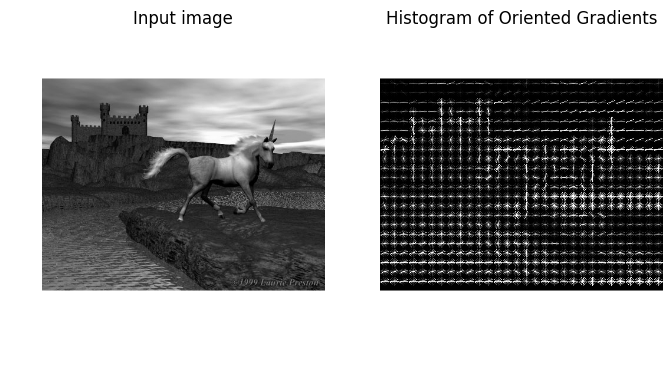

In [55]:
# Histogram of Oriented Gradients (HOG) = object detection 

import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, color, exposure

#image = color.rgb2gray(data.astronaut())
image = uni_gray_og

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')
plt.show()

In [56]:
hog_image.max()

0.15838798554614186

### Ex 3: Color Channels 

In [10]:
def most_frequent_colour(image):

    w, h = image.size
    pixels = image.getcolors(w * h)

    most_frequent_pixel = pixels[0]

    for count, colour in pixels:
        if count > most_frequent_pixel[0]:
            most_frequent_pixel = (count, colour)

    return most_frequent_pixel[1]

def get_multi_feats(image_path_list):
    feature_list = []
    for image_path in image_path_list:
        img_og = imread(image_path)
        feat_size = img_og.size
        
        img_r = img_og[:, :, 0]
        img_g = img_og[:, :, 1]
        img_b = img_og[:, :, 2]
        
        # Contrast stretching
        p2, p98 = np.percentile(img_og, (2, 98))
        r_rescale = exposure.rescale_intensity(img_r, in_range = (p2, p98))
        g_rescale = exposure.rescale_intensity(img_g, in_range = (p2, p98))
        b_rescale = exposure.rescale_intensity(img_b, in_range = (p2, p98))

        # Equalization
        r_eq = exposure.equalize_hist(img_r)
        g_eq = exposure.equalize_hist(img_g)
        b_eq = exposure.equalize_hist(img_b)

        # Adaptive Equalization
        r_adapteq = exposure.equalize_adapthist(img_r, clip_limit = 0.03)
        g_adapteq = exposure.equalize_adapthist(img_g, clip_limit = 0.03)
        b_adapteq = exposure.equalize_adapthist(img_b, clip_limit = 0.03)
        
        # Summary Statistics 
        
        
        #top_pixel = pixels[0]
        #for count, color in feat_pixels:
        #    if count > top_pixel[0]:
        #        top_pixel = (count, color)
        #feat_dom = top_pixel[1]
        
        feature_list.append([image_path, feat_size, r_rescale, r_eq, r_adapteq])
    return feature_list

In [12]:
def get_channel_summary(img):
        img_r = img[:, :, 0]
        img_g = img[:, :, 1]
        img_b = img[:, :, 2]
        
        r_mean = np.mean(img_r)
        r_median = np.median(img_r)
        r_std = np.std(img_r)
        r_var = np.var(img_r)
        
        g_mean = np.mean(img_g)
        g_median = np.median(img_g)
        g_std = np.std(img_g)
        g_var = np.var(img_g)
        
        b_mean = np.mean(img_b)
        b_median = np.median(img_b)
        b_std = np.std(img_b)
        b_var = np.var(img_b)
        
        return list([r_mean, r_median, r_std, r_var, g_mean, g_median, g_std, g_var, b_mean, b_median, b_std, b_var])

In [13]:
setWorkDir(os.path.join(os.getcwd(), 'unicorn'))


New working directory:  /Users/kschocz/Documents/berkeley-courses/second-year/fall16/python-ds-seminar/homeworks/hw7/sample_img/unicorn


True

In [14]:
getWorkDir()

'/Users/kschocz/Documents/berkeley-courses/second-year/fall16/python-ds-seminar/homeworks/hw7/sample_img/unicorn'

In [63]:
MYDIRECTORY

'/Users/echoes/Documents/berkeley-courses/second-year/fall16/python-ds-seminar/homeworks/hw7/sample_img'

In [99]:
# We first collect all the local paths to all the images in one list
image_paths = []
categories = listdir(MYDIRECTORY)
for category in categories:
    image_names = listdir(MYDIRECTORY  + "/" + category)
    for name in image_names:
        image_paths.append(MYDIRECTORY + "/" + category + "/" + name)

print("There should be 4244 images, actual number is " + 
    str(len(image_paths)) + ".")

There should be 4244 images, actual number is 811.


In [101]:
just_corn_path = image_paths[746:811]
just_corns = get_multi_feats(just_corn_path)

In [127]:
from scipy import stats

# ...[0] = img path 
# ...[1] = img size 
# ...[2] = img r rescale 
# ...[3] = img r histogram equalization 
# ...[4] = img r histogram adaptive eq.

np.mean(just_corns[0][2])

92.165777083333339

In [128]:
np.median(just_corns[0][2])

70.0

In [130]:
np.min(just_corns[0][2])

0

In [132]:
np.max(just_corns[0][2])

255

In [134]:
np.var(just_corns[0][2])

5078.3603742086407

In [12]:
np.std(just_corns[0][2])

NameError: name 'just_corns' is not defined

In [14]:
foo = get_channel_summary(uni_og)
bar = get_channel_summary(uni_og)
foo

[87.815943287037044,
 63.0,
 63.337050104583241,
 4011.5819159504881,
 90.23715277777778,
 65.0,
 60.075805482684345,
 3609.1024043933262,
 74.902054398148152,
 55.0,
 54.0729099520902,
 2923.8795906868554]

In [16]:
wowie = foo + bar
wowie

[87.815943287037044,
 63.0,
 63.337050104583241,
 4011.5819159504881,
 90.23715277777778,
 65.0,
 60.075805482684345,
 3609.1024043933262,
 74.902054398148152,
 55.0,
 54.0729099520902,
 2923.8795906868554,
 87.815943287037044,
 63.0,
 63.337050104583241,
 4011.5819159504881,
 90.23715277777778,
 65.0,
 60.075805482684345,
 3609.1024043933262,
 74.902054398148152,
 55.0,
 54.0729099520902,
 2923.8795906868554]

In [ ]:
feat_size = image_array.size
#feat_pixels = image_array.getcolors(feat_width * feat_height)
top_pixel = pixels[0]

for count, color in feat_pixels:
    if count > top_pixel[0]:
        top_pixel = (count, color)

feat_dom = top_pixel[1]

### Ex 4: K-means of Channels 

Cluster pixels based on similarly colored pixels. 

### Template Matching 

Uses normalized cross-correlation to find templates within images.

In [126]:
uni_gray_og.shape

(360, 480)

In [128]:
hog_image

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import match_template

## Find extracted HOG template in grayscale image 
result = match_template(uni_gray_og, hog_image)
#ij = np.unravel_index(np.argmax(result), result.shape)
#x, y = ij[::-1]


In [123]:
## Output of match_template = [-1, 1] array = correlation at given positions 

result

array([[-0.05009029]], dtype=float32)

In [ ]:
fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, adjustable='box-forced')
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2, adjustable='box-forced')

ax1.imshow(coin)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(image)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hcoin, wcoin = coin.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

## Step 4: Extract features

Now that we've got our data, we need to convert our images into features that can be used by machine learning algorithms.  

For this example (from text newsgroup example via class), we'll use lexical features: each word is a feature, and it's value is the number of times that word occurs in a text. 

To do for **get_features**:

1. integrate with **extract_features()** above - append img path w feature results 
2. turn everything into numpy (or related) numeric data structures 



In [99]:
from collections import defaultdict

def get_features(documentt):
    """Convert a post into a dictionary of features"""
    features = defaultdict(int)
    #for word in documentt:
    #    if word.isalpha():
    #        features[word.lower()] += 1
    return features

bar = get_features(uni_og)

#get_features(newsgroups.words(fileids = trainSet[0]))

In [100]:
bar

defaultdict(int, {})

# Step XXX: Predicting with Random Forest 

### Run cross validation and get predictive score

We can split the data, train, and check predictive strength using cross validation. 

In [31]:
from sklearn.cross_validation import cross_val_score

# 0 - 1 scaling of data 
# X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)

# Bring in data 
#dat_file = requests.get("http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data")
#data = StringIO(dat_file.text)
#ddat = np.loadtxt(data)
#xDat, xTest, yDat, yTest = splitScale(ddat, 0.7)